### 1) Normal Distribution

#### Having a normally distributed data is advantageous because normal distributions have some alluring properties, like the sample mean and sample variance being the best estimators of population mean and population variance. This is not true for all other possible probability distribution, nevertheless the sample means and sample variance themselves will be normally distributed for any probability distribution.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from fitter import Fitter, get_distributions
import seaborn as sns

In [3]:
belize = pd.read_csv('belize_airbnb_listings.csv')
b_con = belize.drop(columns = {'id', 'name', 'host_name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review'})
b_con = b_con.dropna()
b_con.head(1)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,17.74786,-88.02398,141,3,250,2.0,5,225


### 2) Histograms

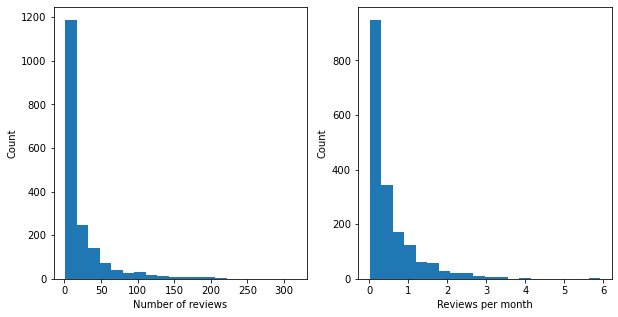

In [4]:
fig, [ax1, ax2] = plt.subplots(figsize = (10 ,5), nrows = 1, ncols = 2)

ax1.hist(b_con['number_of_reviews'], bins = 20)
ax1.set_xlabel('Number of reviews')
ax1.set_ylabel('Count')

ax2.hist(b_con['reviews_per_month'], bins = 20)
ax2.set_xlabel('Reviews per month')
ax2.set_ylabel('Count')

plt.show()



#### Both sets have a lot of data so I chose to use 20 as binsize. Above this some bins would run very thin though

### 3) Boxplot

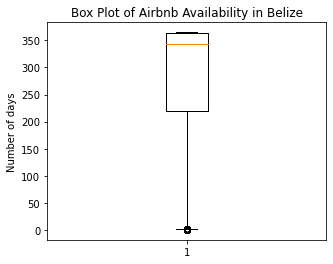

count    1810.000000
mean      278.848619
std       119.115732
min         0.000000
25%       219.000000
50%       344.000000
75%       364.000000
max       365.000000
Name: availability_365, dtype: float64


In [5]:
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(1, 1, 1)
bp = ax.boxplot(b_con['availability_365'])

plt.ylabel('Number of days')
plt.title("Box Plot of Airbnb Availability in Belize")
plt.show()

print(b_con['availability_365'].describe())

#### Most places are available for between 219 and 364 days and there seem to be only a few outliers (vailable for 2-3 days)

### 4) Probability of price being under 50 dollars

Text(0, 0.5, 'Count')

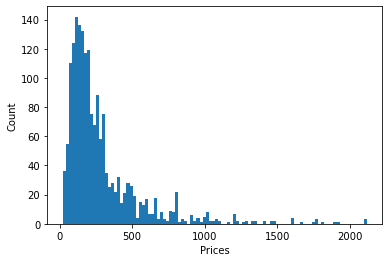

In [9]:
#delete the 10 highest outliers (about 0.5% of data)
dropped = b_con['price'].sort_values()[:-10].to_frame()

fig, ax = plt.subplots()

ax.hist(dropped['price'], bins = 100)
ax.set_xlabel('Prices')
ax.set_ylabel('Count')

#### This looks a bit more like invers Gaussian as opposed to normal

In [10]:
prices = dropped['price'].values

,sumsquare_error,aic,bic,kl_div
burr,0.000002,1885.552791,-36768.176895,inf
mielke,0.000002,1885.537195,-36768.115601,inf
genextreme,0.000002,1888.490406,-36757.842426,inf
invweibull,0.000002,1888.490383,-36757.841860,inf
burr12,0.000002,1887.301812,-36702.244266,inf


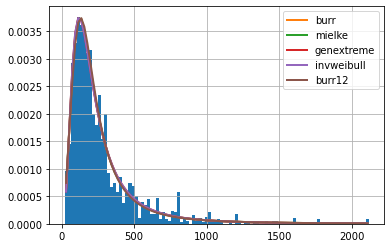

In [14]:
f = Fitter(prices)
f.fit()
f.summary()

#### The inverse Gaussian distribution timed out, so let's maybe check only that one separately

,sumsquare_error,aic,bic,kl_div
norminvgauss,0.000004,1918.823659,-36064.683788,inf


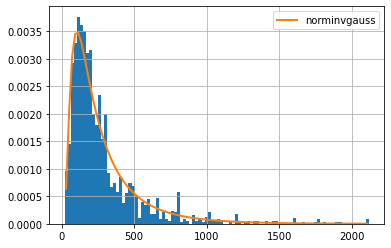

In [15]:
f2 = Fitter(prices, distributions = ['norminvgauss'], timeout = 180)
f2.fit()
f2.summary()

#### Indeed it is worse than inverse Gamma, from now on we will assume price data is fitted best with inverse Gamma. In priciple we should compare it with the other 4 good fits using other metrics, but I am an amateur statistician...

In [16]:
(alpha, lo, beta) = f.fitted_param['invgamma']
beta

569.2782972231038

In [17]:
ss.invgamma.cdf(50, alpha, loc = lo, scale = beta)

0.026858929974465002

#### The probability of price being below 50 dolars is 2.7 percent

### 5) Sample variance and standard deviations

#### Will randomly select 100 rows 50000 times and calculate sample statistics for those

In [18]:
b_con.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [19]:
variances ={'latitude' : [], 'longitude' : [], 'price' : [], 'minimum_nights' : [], 'number_of_reviews' : [], 'reviews_per_month' : [], 'calculated_host_listings_count' : [], 'availability_365' : []}
stds = {'latitude' : [], 'longitude' : [], 'price' : [], 'minimum_nights' : [], 'number_of_reviews' : [], 'reviews_per_month' : [], 'calculated_host_listings_count' : [], 'availability_365' : []}

for i in range(50000):
    sample = b_con.sample(n=100)
    for column in b_con:
        variances[column].append(sample.var()[column])
        stds[column].append(sample.std()[column])
    



/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


### Distribution of sample variances

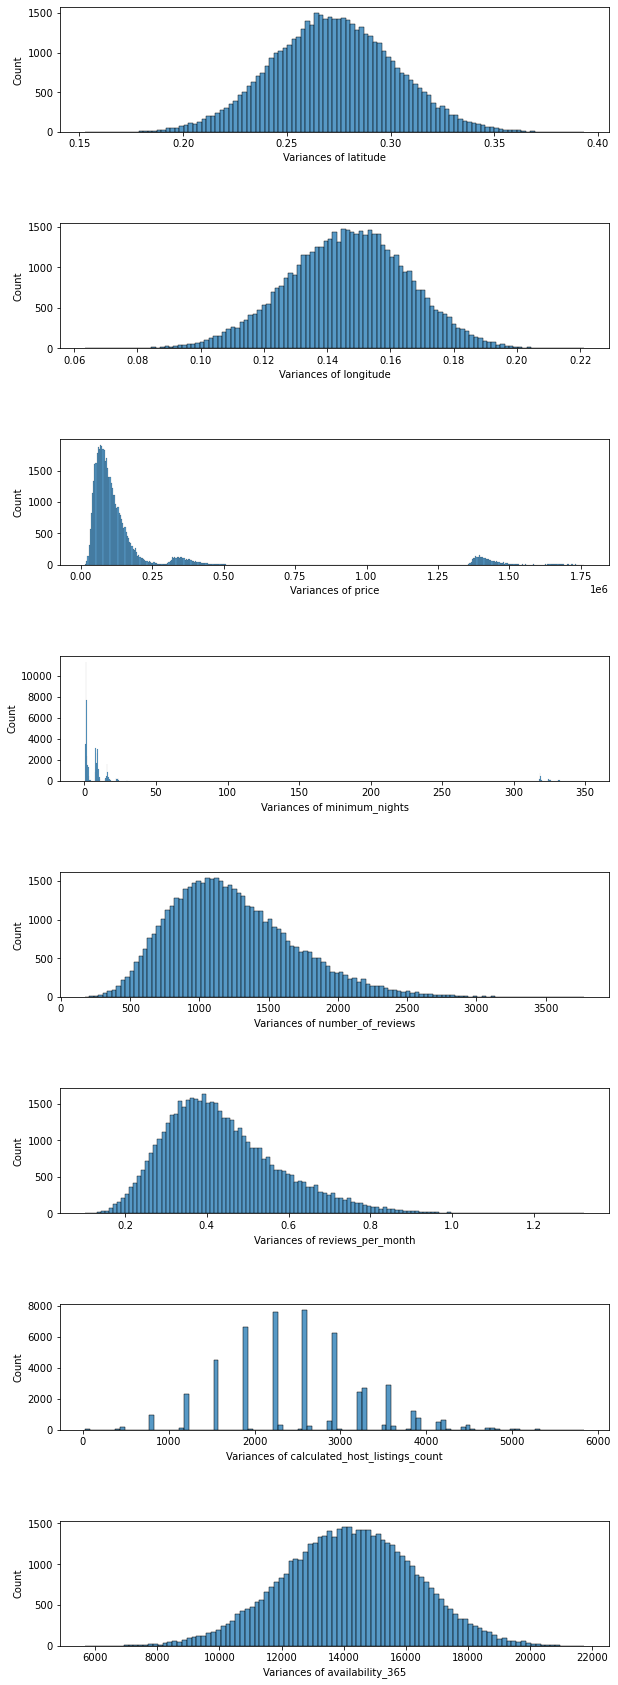

In [20]:
fig, axes = plt.subplots(8, 1, figsize = (10, 25))
fig.tight_layout(pad = 7.0)
count = 0

for i in b_con.columns:
    sns.histplot(variances[i], ax = axes[count])
    axes[count].set_xlabel(f'Variances of {i}')
    count += 1


#### This was kinda surprising: I thought distribution of the sample variances for all of these would follow normal distribution if I take enough samples, so looked into literture and no, they do not follow a normal, but a chi-square distribution...

### Distribution of sample standard deviations

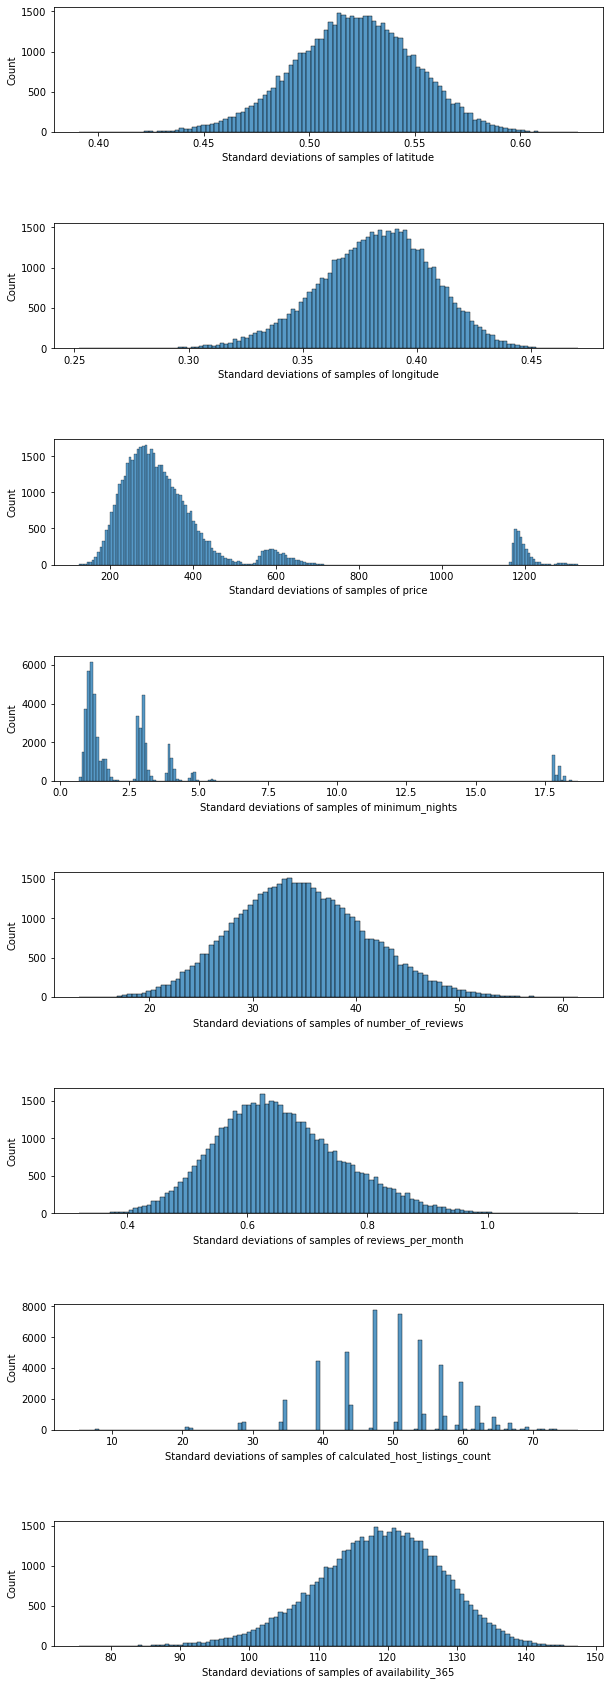

In [21]:
fig, axes = plt.subplots(8, 1, figsize = (10, 25))
fig.tight_layout(pad = 7.0)
count = 0

for i in b_con.columns:
    sns.histplot(stds[i], ax = axes[count])
    axes[count].set_xlabel(f'Standard deviations of samples of {i}')
    count += 1

#### These approach more the normal distribution, but not all of them. Why is that?

In [6]:
b_con.var().to_frame()

,0
latitude,0.272235
longitude,0.146532
price,185065.024734
minimum_nights,22.960767
number_of_reviews,1245.207503
reviews_per_month,0.438448
calculated_host_listings_count,2536.543335
availability_365,14188.557502


In [7]:
b_con.std().to_frame()

,0
latitude,0.521762
longitude,0.382794
price,430.191846
minimum_nights,4.791739
number_of_reviews,35.287498
reviews_per_month,0.662154
calculated_host_listings_count,50.364108
availability_365,119.115732


#### 5a) To be honest it is not quite clear why the sample variance and std had to be calculated here if we calculate them over the whole population

#### 5b) Price, number of reviews, calculated host listings count and availability have very big std-s: this could already be estimated from the boxplots for the corresponding data

#### 5c) The scale of measurement for all of these is a ratio scale

### 6) Distribution of Availability 

#### 6a) 360 days or more

In [24]:
round(100-ss.percentileofscore(b_con['availability_365'], 360, kind = 'strict'), 2)

36.69

#### 360 days or less

In [25]:
round(ss.percentileofscore(b_con['availability_365'], 360, kind = 'weak'), 2)

64.53

#### They do not add to 100, because 360 days are included in both

#### 6b)

Text(0, 0.5, 'Count')

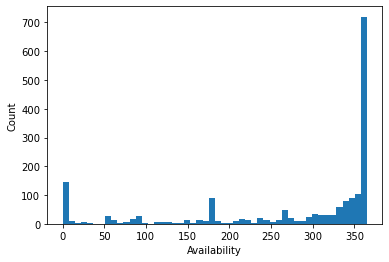

In [26]:
fig, ax = plt.subplots()

ax.hist(b_con['availability_365'], bins = 50)
ax.set_xlabel('Availability')
ax.set_ylabel('Count')

,sumsquare_error,aic,bic,kl_div
levy_l,0.001178,1550.537996,-25769.173116,inf
gennorm,0.002710,1583.224105,-24252.987140,inf
beta,0.004266,1335.738732,-23424.098177,inf
genhalflogistic,0.006612,1239.781498,-22638.488177,inf
gompertz,0.006831,inf,-22579.638643,0.862858


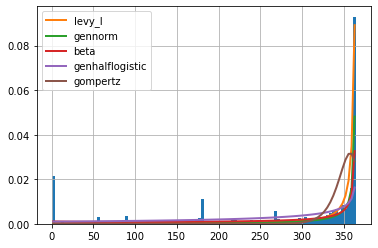

In [27]:
availability = b_con['availability_365'].dropna().values

f = Fitter(availability)
f.fit()
f.summary()

#### To be honest, really no fit is excellent, levy_l being the best. Am I looking at the right data?

### 7) Minimal night count of which 75 percent of listings are greater than

In [9]:
b_con['minimum_nights'].quantile(0.25)

1.0

In [8]:
b_con['minimum_nights'].dropna().quantile(0.25)

1.0

#### Looks like it comes to be 2 nights

### 8) The Monty Hall Problem

#### Given are 3 doors, behind one of which there is a prize. Have to choose one door (1/3 probability of right choice) after which one of the other two is opened (not randomly, the gatekeeper knows which to open not to reveal the prize). The question is if it is worth to change to the other unopened door? Answer is yes, as the probability of the prize being behind that door is 2/3 (initial probability of it being behind one of the two unchosen doors of which ine was reveaed since).

### 9) Certificates

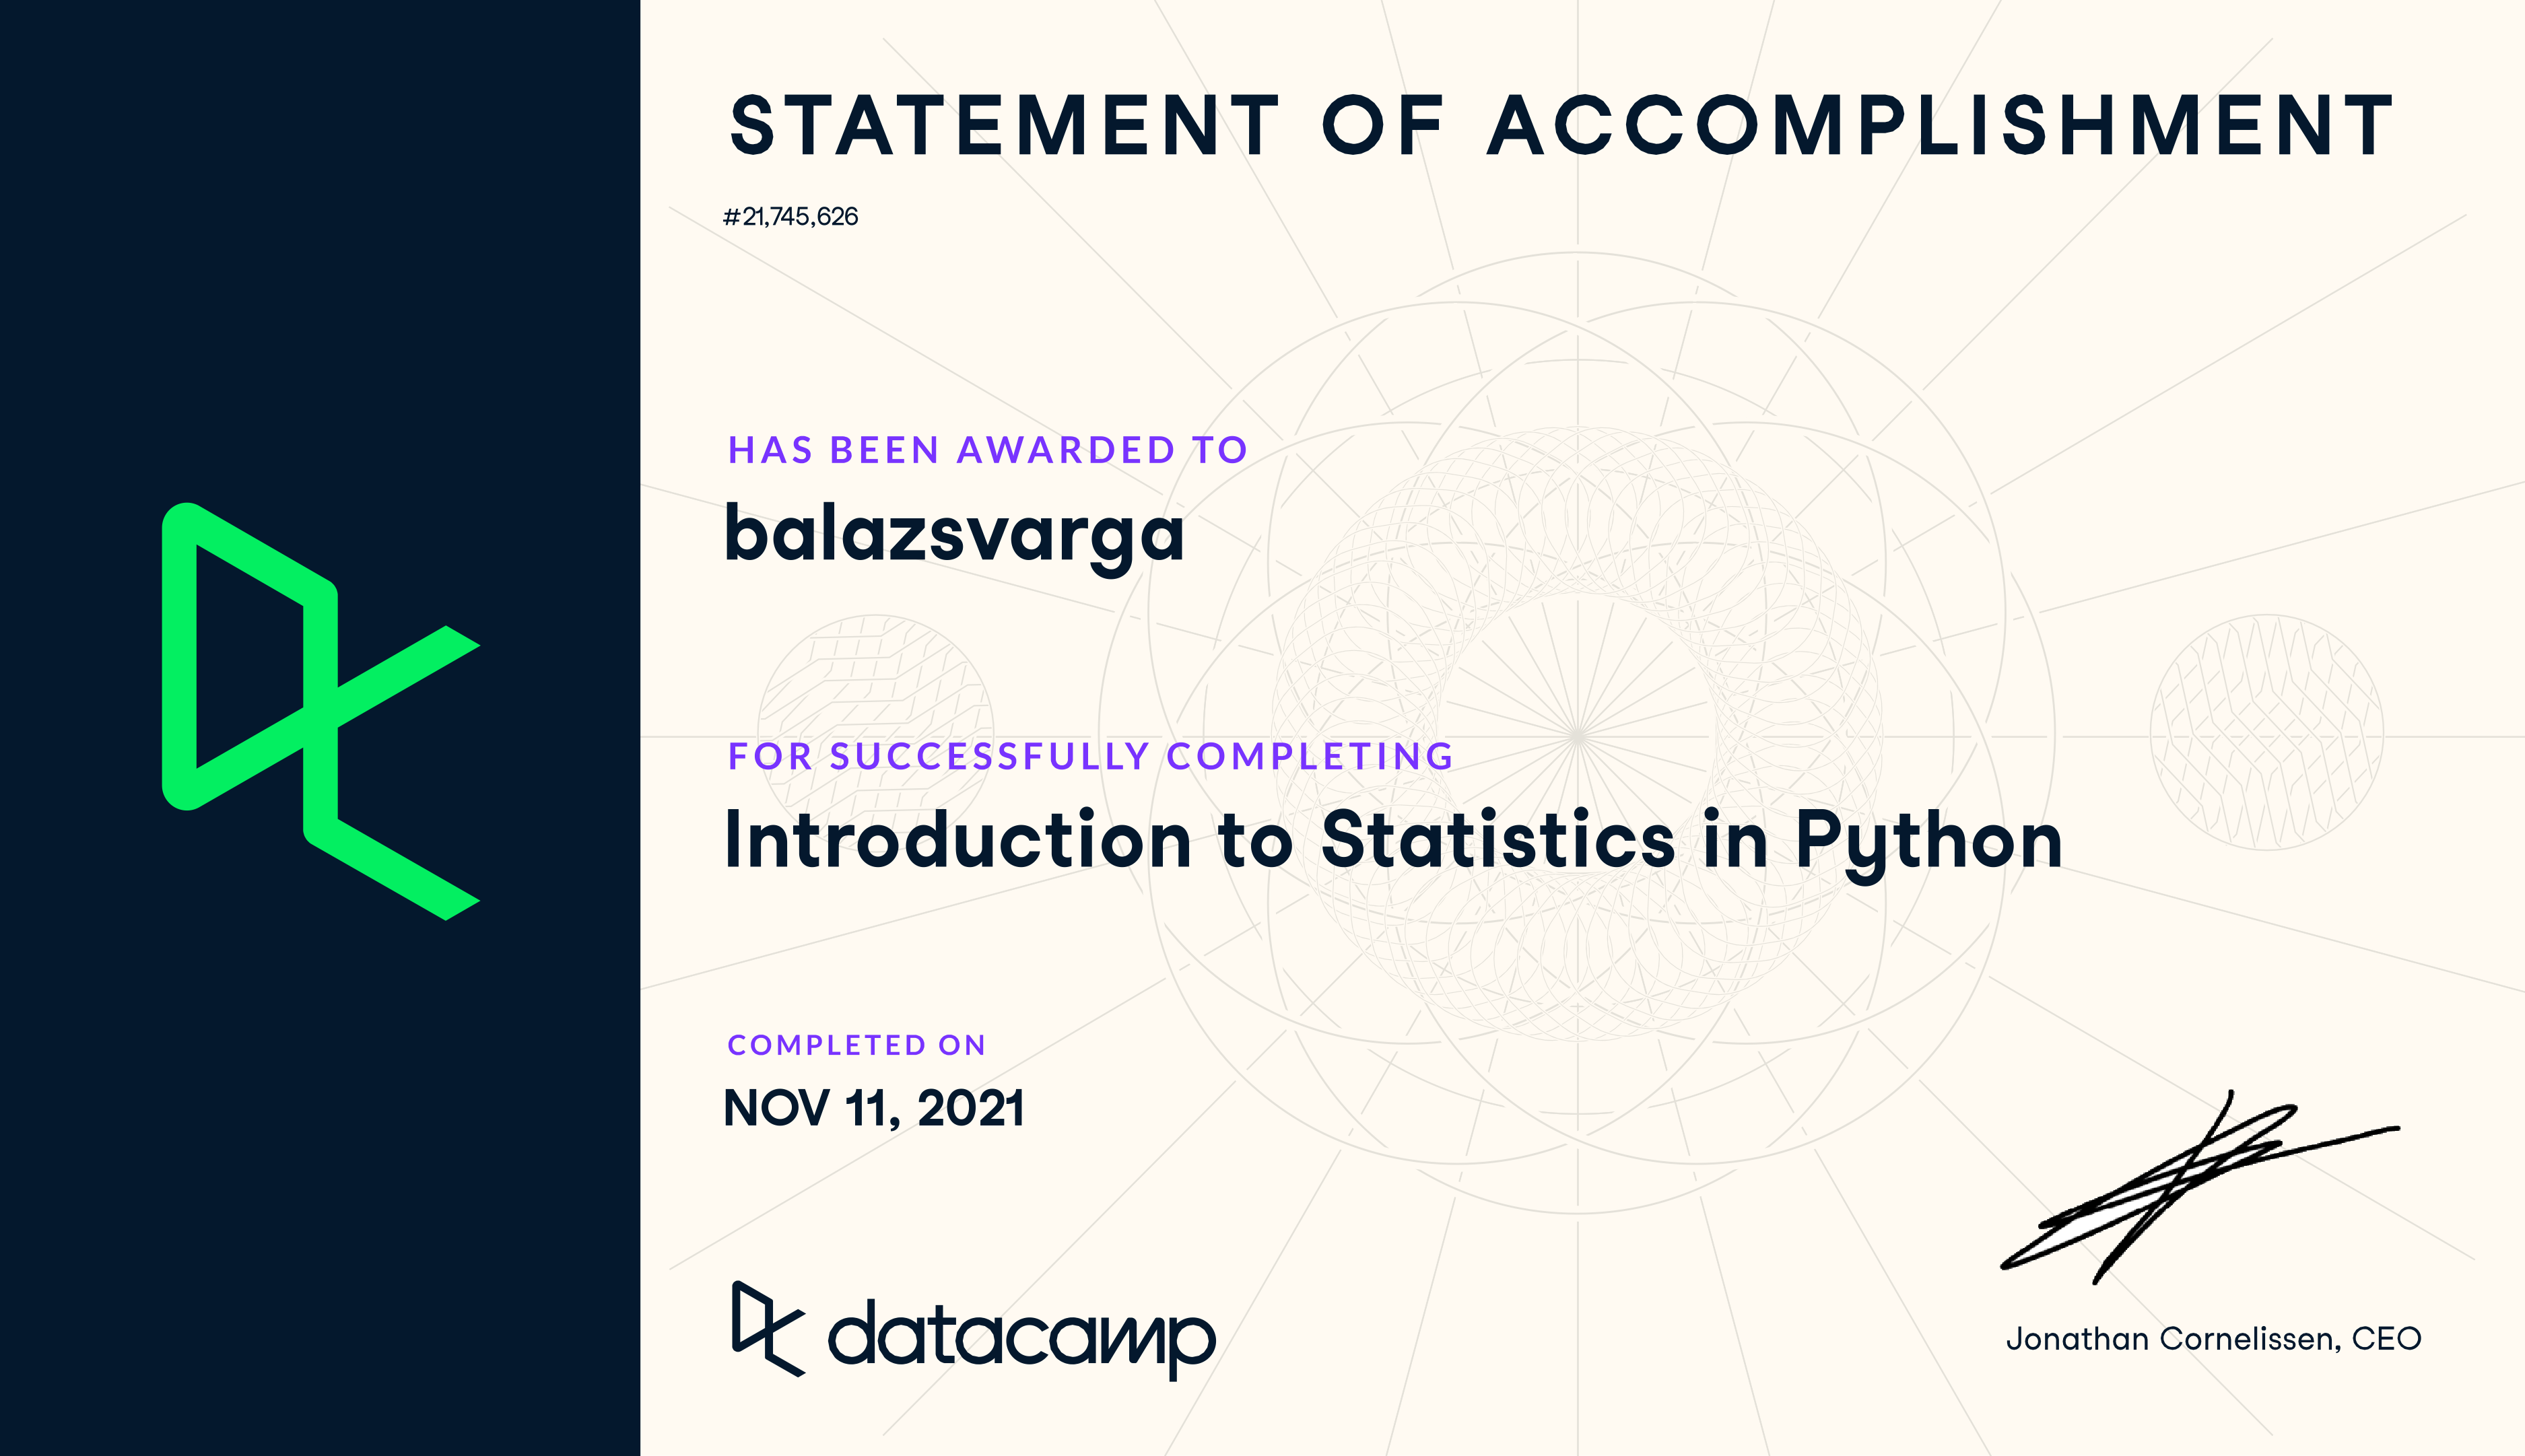

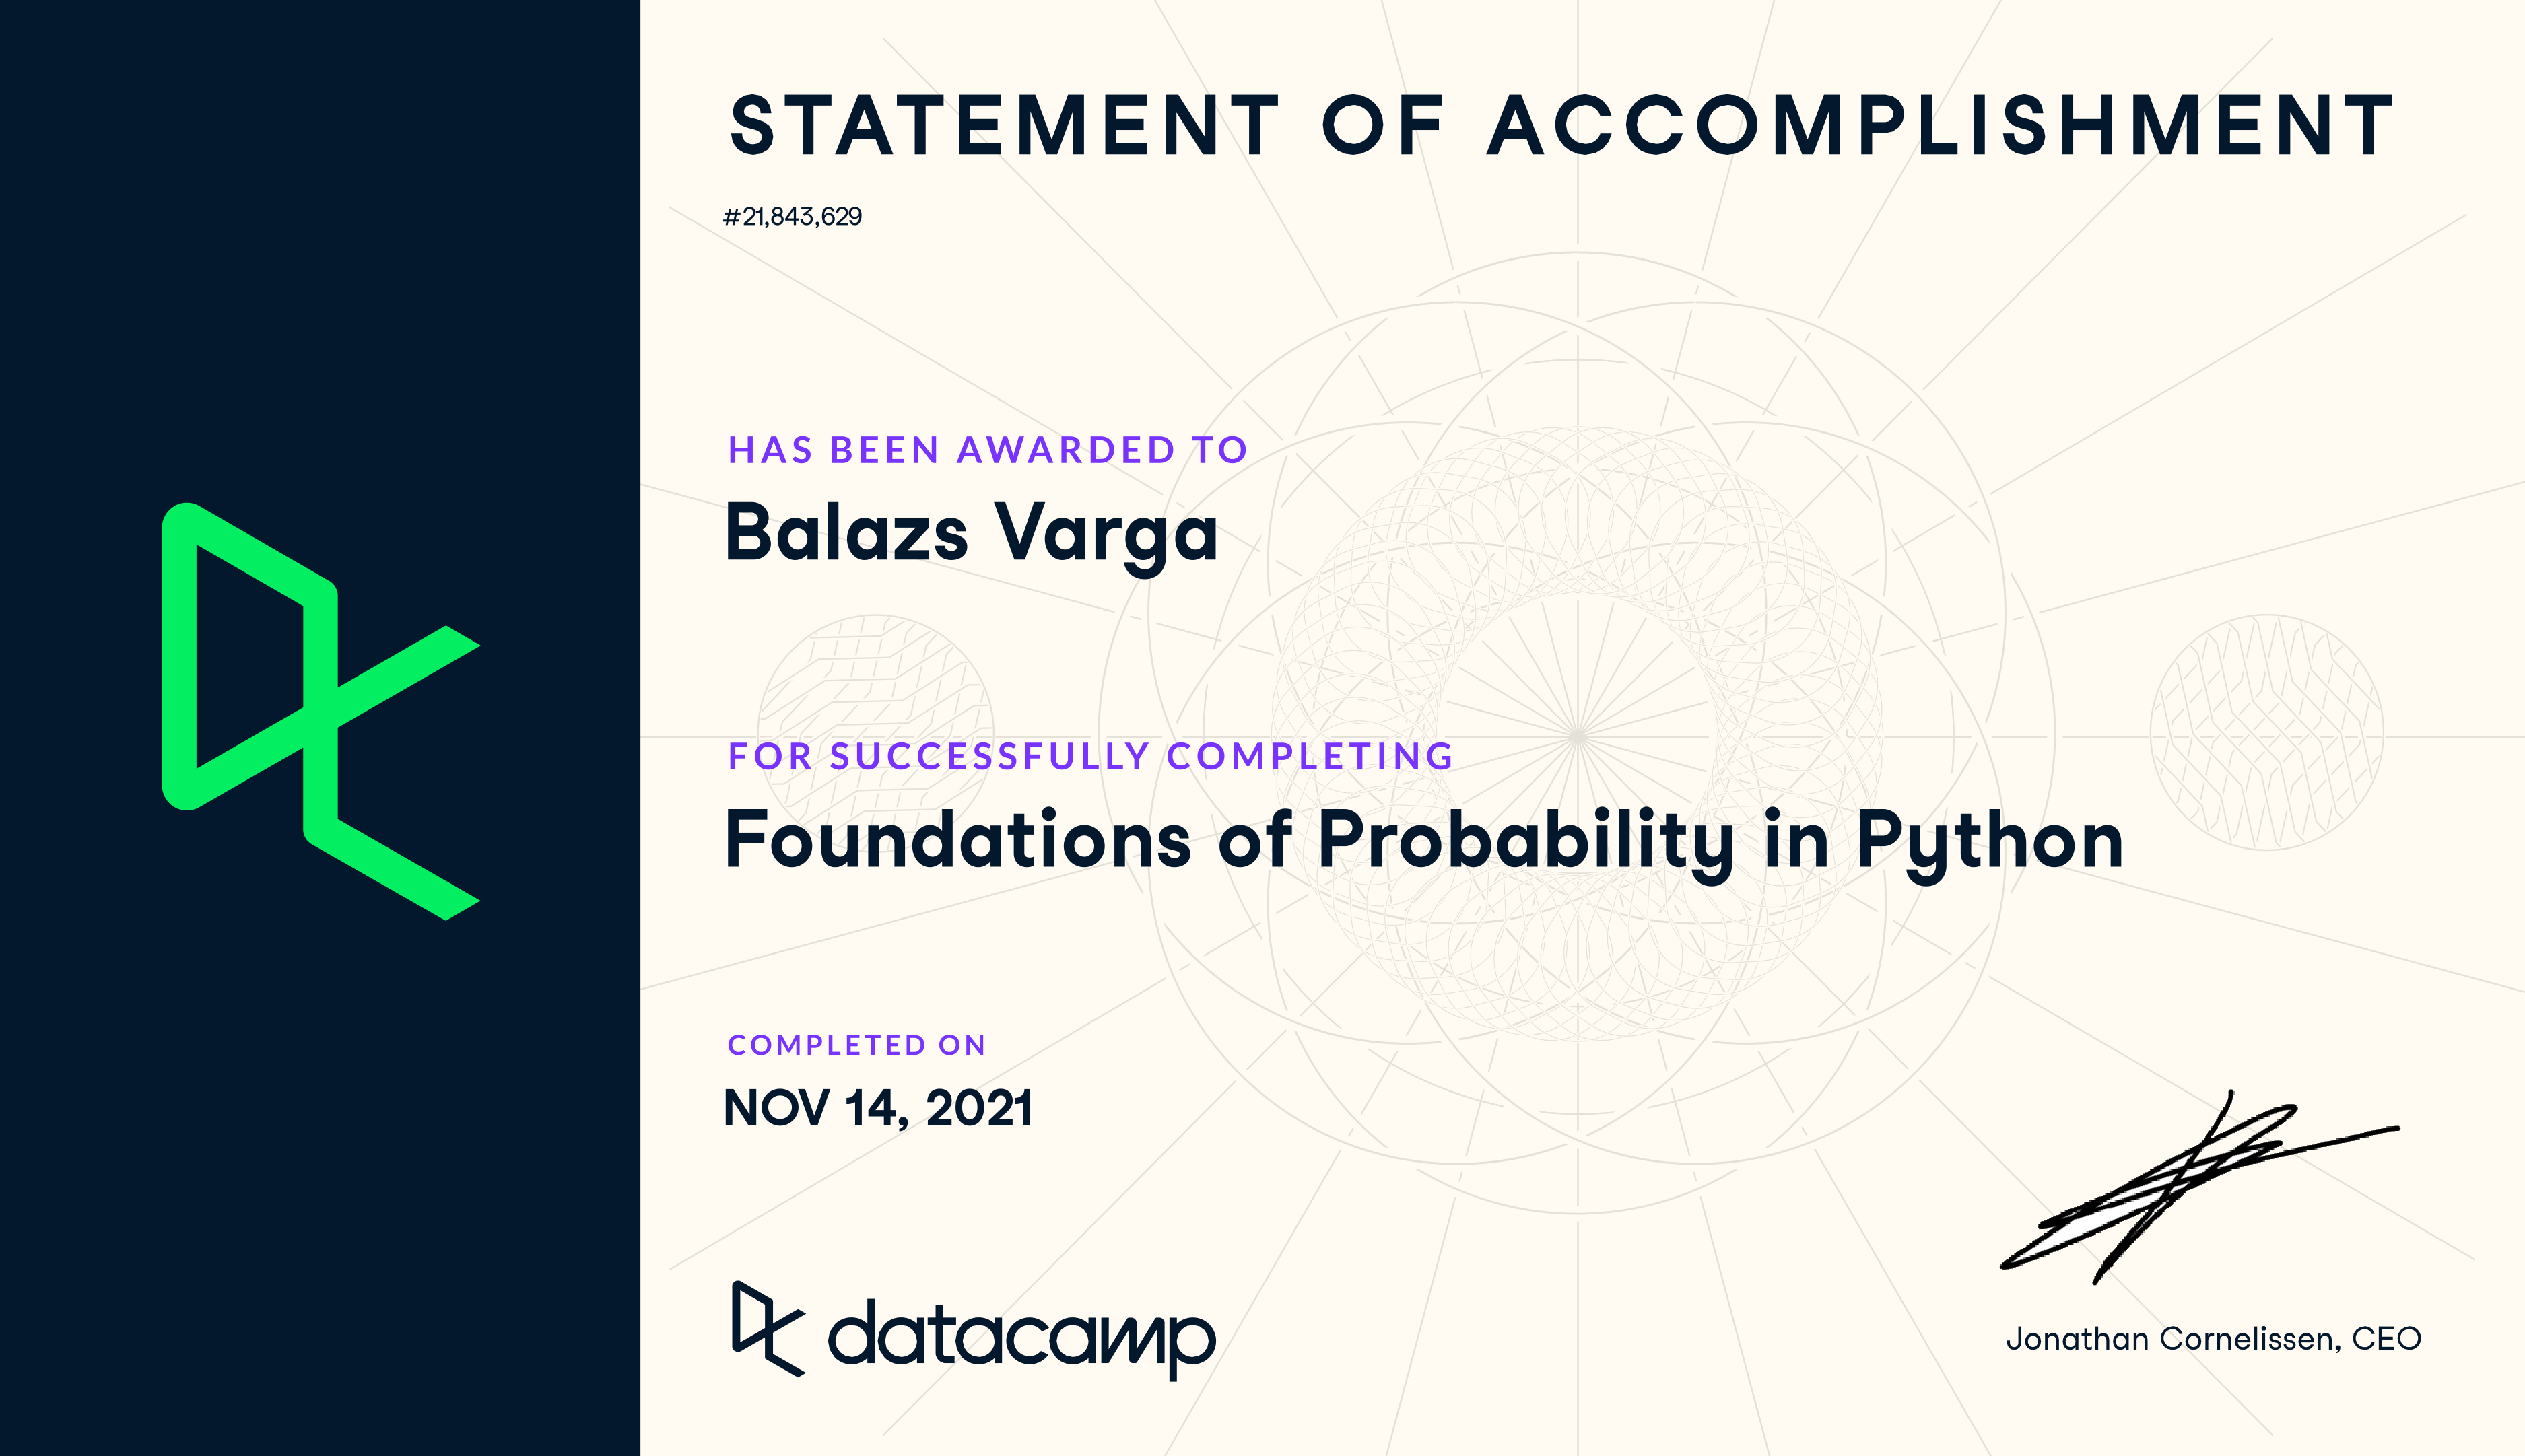